<a href="https://colab.research.google.com/github/juhhg/RC-Tutorial-2023/blob/main/chapter_4_memory_capacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter IV: Memory Capacity


In this chapter, we introduce a measure to evaluate past inputs held in the reservoir called an memory capacity.

### Goals in Chapter IV
- Understand memory function and memory capacity
- Understand relationship between dynamics and memory capacity of the echo state network


### Memory Function
The state equation is described by
$$
x_{t} = g(x_{t-1},u_{t-1})
$$
Let $u_t$ be a random number following the uniform distribution in the range of $[-1,1]$.
The target output is the input delayed by $\tau$ steps
\begin{align}
y_t^{(\tau)} &= u_{t-\tau}~(\tau=1,2,\ldots).
\end{align}
Note that, if the dynamics is described by the equation where the current state is determined by the current input. i.e.,
$$
x_t = g(x_{t-1},u_t),
$$
the delay should be zero-based $(\tau=0,1,2,\ldots)$ because $x_t$ can hold $u_t$.
This happens in some analytical and physical reservoir cases.

The output is given by
\begin{align}
\hat{y}_t &= \hat{w}_0 + \sum_{i=1}^N \hat{w}_i x_{i,t}
\end{align}
where the optimum weights are calculated by the linear regression.
The normalized mean square error (NMSE) is
$$
{\rm NMSE} = \frac{\sum_{t=T_{\rm train}+1}^{T_{\rm train}+T_{\rm eval}} (y_t-\hat{y}_t)^2}{\sum_{t=T_{\rm train}+1}^{T_{\rm train}+T_{\rm eval}} y_t^2}.
$$

The memory function is defined by
\begin{align}
f(\tau) = 1-{\rm NMSE}.
\end{align}
Ideally, as $0\le{\rm NMSE}\le1$,
$$
0\le f(\tau)\le1.
$$


### Memory Capacity
A memory capacity (MC) is descibed by the sum of memory function over delay $\tau$
$$
{\rm MC} = \sum_{\tau=1}^\infty f(\tau).
$$
The MC is bounded by the number of nodes $N$, i.e.,
$$
{\rm MC} \le N.
$$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp

# Class of ESN (for a single task)
class ESN():
    def __init__(self,N,rho,sigma,p,pin,rseed=0):
        self.N,self.rho,self.sigma,self.p,self.pin = N,rho,sigma,p,pin
        np.random.seed(rseed)
        W = np.random.uniform(-1,1,(N,N))*(np.random.uniform(0,1,(N,N))<p)
        eigs = np.linalg.eigvals(W)
        self.W = rho*W/np.max(np.abs(eigs))
        np.random.seed(rseed+1)
        self.Win = np.random.uniform(-sigma,sigma,N)*(np.random.uniform(0,1,N)<pin)

    def run(self,u,f=np.tanh,X0=[]):
        if len(X0)==0:
            X0 = np.ones(self.N)
        T = len(u)
        X = np.zeros((T,self.N))
        X[0] = X0
        for t in range(1,T):
            X[t] = f(self.W @ X[t-1] + self.Win*u[t-1])
        return X

    def washout(self,X,Two):
        T = X.shape[0]-Two
        Xwo = np.hstack([X[Two:],np.ones((T,1))])
        return Xwo

    def linear_regression(self,Xwo,ywo,Ttrain):
        # Split time-series into training and evaluation phases
        Xtrain, Xeval = Xwo[:Ttrain], Xwo[Ttrain:]
        ytrain, yeval = ywo[:Ttrain], ywo[Ttrain:]
        # Calculate wout and output
        wout = np.linalg.pinv(Xtrain) @ ytrain
        yhat = Xeval @ wout
        # Normalized mean square error
        nmse = np.mean((yhat - yeval) ** 2)/np.mean(yeval**2)
        return yeval,yhat,nmse


X_washout (2000, 51)
MC 20.633748707490486


Text(0.5, 1.0, '$\\rho=0.9, {\\rm MC}=\\sum_{\\tau}f(\\tau)=20.6$')

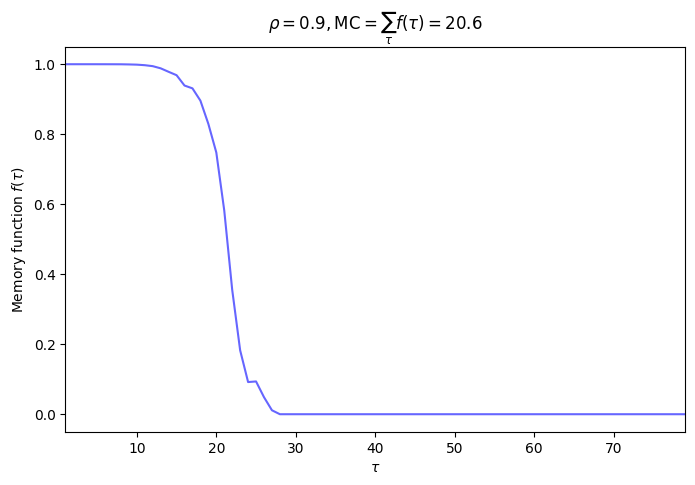

In [ ]:
# Identity function f(x) = x
identity = lambda x : x

# Parameters
Two,Ttrain,Teval = 1000,1000,1000
T = Ttrain + Teval

N = 50
rho = 0.9
sigma = 0.1
p,pin = 1,1

# Input
np.random.seed(0)
u_asym = np.random.rand(Two+T)
u_sym = 2*u_asym - 1

esn = ESN(N,rho,sigma,p,pin)
# X = esn.run(u_sym,f=identity)
X = esn.run(u_sym,f=np.tanh)
Xwo = np.hstack([X[Two:],np.ones((T,1))])
print('X_washout',Xwo.shape)

# Parameters for MC
taus = np.arange(1,80)

mf = []
for tau in taus:
    # Target {u(Two-tau),u(Two-tau+1),...,u(Two+T-tau)} must be in the symmetric range
    ywo = u_sym[Two-tau:Two+T-tau].reshape((T,1))
    yeval,yhat,nmse = esn.linear_regression(Xwo,ywo,Ttrain)
    f = 1- nmse
    mf.append(f)
    # print('tau',tau,'mf',f)
mf = np.array(mf)
mf = mf*(mf>0)
mc = mf.sum()
print('MC',mc)

fig,ax = plt.subplots(figsize=(8,5))
ax.plot(taus,mf,color='blue',alpha=0.6)
ax.set_xlim(taus.min(),taus.max())
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'Memory function $f(\tau)$')
ax.set_title(r'$\rho=%.1f, {\rm MC}=\sum_{\tau}f(\tau)=%.1f$'%(rho,mc))



rho 0.1 mc 8.279042947536073
rho 0.2 mc 9.630103984509647
rho 0.30000000000000004 mc 10.757302193670318
rho 0.4 mc 11.719249980417835
rho 0.5 mc 12.944061269287342
rho 0.6 mc 14.581679830256803
rho 0.7000000000000001 mc 16.531001097328158
rho 0.8 mc 18.594579142326864
rho 0.9 mc 20.630798361891813
rho 1.0 mc 22.75172706685526
rho 1.1 mc 18.670242962726903
rho 1.2000000000000002 mc 18.374431274396557
rho 1.3000000000000003 mc 17.763212674095655
rho 1.4000000000000001 mc 16.664485420334184


Text(0, 0.5, 'Memory capacity')

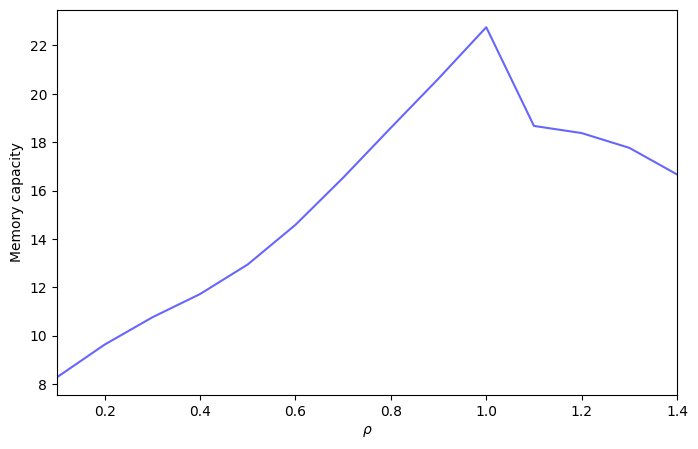

In [ ]:
# Identity function f(x) = x
identity = lambda x : x

# Parameters for ESN
Two,Ttrain,Teval = 1000,1000,1000
T = Ttrain + Teval
N = 50
rhos = np.arange(0.1,1.5,0.1)
sigma = 0.1
p,pin = 1,1

# Input
np.random.seed(0)
u_asym = np.random.rand(Two+T)
u_sym = 2*u_asym - 1

# Parameters for MC
taus = np.arange(1,80) #delay

mcs = []
for rho in rhos:
    esn = ESN(N,rho,sigma,p,pin)
    # X = esn.run(u_sym,f=identity)
    X = esn.run(u_sym,f=np.tanh)
    Xwo = np.hstack([X[Two:],np.ones((T,1))])

    mf = []
    for tau in taus:
        # Target {u(Two-tau),u(Two-tau+1),...,u(Two+T-tau)} must be in the symmetric range
        ywo = u_sym[Two-tau:Two+T-tau].reshape((T,1))
        yeval,yhat,nmse = esn.linear_regression(Xwo,ywo,Ttrain)
        f = 1- nmse
        mf.append(f)
    mf = np.array(mf)
    mf = mf*(mf>0)
    mc = mf.sum()
    mcs.append(mc)
    print('rho',rho,'mc',mc)

fig,ax = plt.subplots(figsize=(8,5))

ax.plot(rhos,mcs,color='blue',alpha=0.6)
ax.set_xlim(rhos.min(),rhos.max())
ax.set_xlabel(r'$\rho$')
ax.set_ylabel('Memory capacity')
# ax.legend(loc="upper right", frameon=False)
# ax.set_title(r'$\rho=%.1f$'%rho)



### Relationship between dynamics and memory capacity


<ipython-input-74-8189f644939a>:43: RuntimeWarning: divide by zero encountered in log
  l = np.log(np.abs(np.linalg.eigvals(M)))/T


rho 0.01 mc 6.999634608079738 lyap -inf
rho 0.02 mc 7.956327211488908 lyap -inf
rho 0.03 mc 8.179439181405188 lyap -inf
rho 0.04 mc 8.70981116391033 lyap -inf
rho 0.05 mc 8.92023584825132 lyap -inf
rho 0.060000000000000005 mc 8.976123004196145 lyap -inf
rho 0.06999999999999999 mc 9.154321875648018 lyap -inf
rho 0.08 mc 9.430358180998804 lyap -inf
rho 0.09 mc 9.675388250911954 lyap -inf
rho 0.09999999999999999 mc 9.831038219161613 lyap -inf
rho 0.11 mc 9.939751902785552 lyap -inf
rho 0.12 mc 10.15674450212829 lyap -inf
rho 0.13 mc 10.41732635316789 lyap -inf
rho 0.14 mc 10.649864463679517 lyap -inf
rho 0.15000000000000002 mc 10.80556246088265 lyap -inf
rho 0.16 mc 10.949327802284325 lyap -inf
rho 0.17 mc 11.10132036583013 lyap -inf
rho 0.18000000000000002 mc 11.259549687652408 lyap -inf
rho 0.19 mc 11.417986676177287 lyap -inf
rho 0.2 mc 11.561988315204475 lyap -inf
rho 0.21000000000000002 mc 11.703076621137244 lyap -inf
rho 0.22 mc 11.868531505514436 lyap -inf
rho 0.23 mc 12.0355960253

Text(0, 0.5, 'Memory capacity')

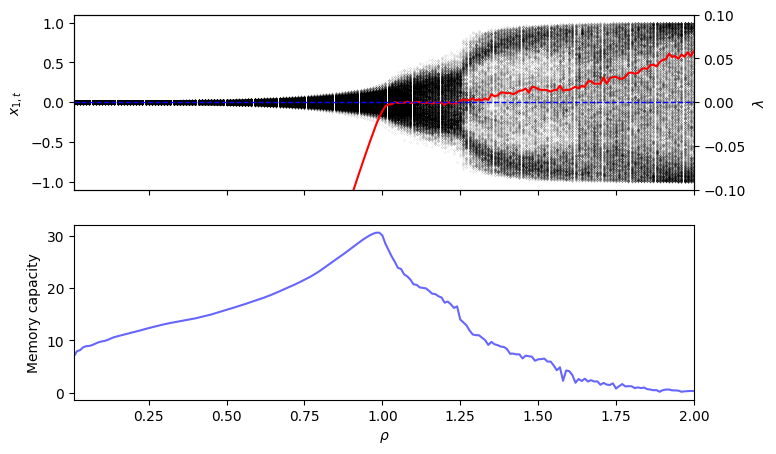

In [ ]:
# Identity function f(x) = x
identity = lambda x : x

# Parameters
Two,Ttrain,Teval = 1000,1000,1000
T = Ttrain + Teval

N = 100
rhos = np.arange(0.01,2.01,0.01)
sigma = 0.1
p,pin = 1,1

# Input
np.random.seed(0)
u_asym = np.random.rand(Two+T)
u_sym = 2*u_asym - 1
# u_sym = np.zeros(Two+T)

# Parameters for MC
taus = np.arange(1,80) #delay

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(211)

mcs,ls = [],[]
for rho in rhos:
    esn = ESN(N,rho,sigma,p,pin)
    # X = esn.run(u_sym,f=identity)
    X = esn.run(u_sym,f=np.tanh)
    Xwo = np.hstack([X[Two:],np.ones((T,1))])
    X0 = X[Two:,0]
    index_positive = sp.signal.find_peaks( X0)[0]
    index_negative = sp.signal.find_peaks(-X0)[0]
    index = np.concatenate([index_positive,index_negative])
    X0 = X0[index]
    ax.plot(rho*np.ones(len(X0)),X0,c='k',marker='.',ms=0.1,ls='')

    M = np.eye(N)
    for t in range(Two,Two+T):
        J = np.diag( 1-X[t]**2 ) @ esn.W
        M = J @ M

    l = np.log(np.abs(np.linalg.eigvals(M)))/T
    ls.append(l.max())

    mf = []
    for tau in taus:
        # Target {u(Two-tau),u(Two-tau+1),...,u(Two+T-tau)} must be in the symmetric range
        ywo = u_sym[Two-tau:Two+T-tau].reshape((T,1))
        yeval,yhat,nmse = esn.linear_regression(Xwo,ywo,Ttrain)
        f = 1- nmse
        mf.append(f)
    mf = np.array(mf)
    mf = mf*(mf>0)
    mc = mf.sum()
    mcs.append(mc)
    print('rho',rho,'mc',mc,'lyap',np.max(l))

ax.set_xlim(rhos.min(),rhos.max())
ax.set_xticklabels([])
ax.set_ylabel(r'$x_{1,t}$')
ax2 = ax.twinx()
ax2.plot(rhos,ls,c='r',ls='-')
ax2.plot([rhos.min(),rhos.max()],[0,0],c='b',ls='--',lw=1)
ax2.set_ylim(-0.1,0.1)
ax2.set_ylabel(r'$\lambda$')

ax = fig.add_subplot(212)
ax.plot(rhos,mcs,color='blue',alpha=0.6)
ax.set_xlim(rhos.min(),rhos.max())
ax.set_xlabel(r'$\rho$')
ax.set_ylabel('Memory capacity')
# ax.legend(loc="upper right", frameon=False)
# ax.set_title(r'$\rho=%.1f$'%rho)



### Homework
Calculate memory function and memory capacity of ESN using a random input following the standard Gaussian distribution $\mathcal{N}(0,1)$ or a random input $\{-1,1\}$ following the Bernoulli distribution.

1. Depict a memory function with $\rho=0.9$ and $\sigma=0.1$.
2. Illustrate the relationship between the spectral radius $\rho(=0.1,0.2,\ldots,1.5)$ and memory capacity ${\rm MC}$.


X_washout (2000, 51)
MC 18.72441970652151


Text(0.5, 1.0, '$\\rho=0.9, {\\rm MC}=\\sum_{\\tau}f(\\tau)=18.7$')

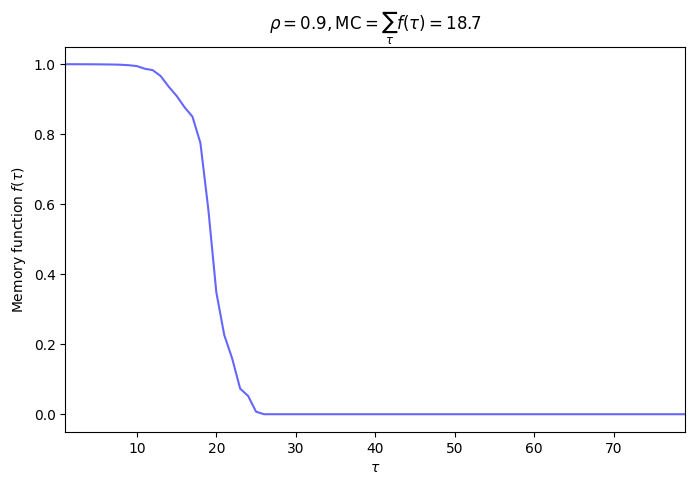

<ipython-input-6-f290fc0156da>:41: RuntimeWarning: divide by zero encountered in log
  l = np.log(np.abs(np.linalg.eigvals(M)))/T


rho 0.01 mc 6.8141169386424 lyap -inf
rho 0.02 mc 6.992383645522047 lyap -inf
rho 0.03 mc 6.998968409156189 lyap -inf
rho 0.04 mc 7.658556550564004 lyap -inf
rho 0.05 mc 7.906826491420446 lyap -inf
rho 0.060000000000000005 mc 7.9680447156271 lyap -inf
rho 0.06999999999999999 mc 8.003794778564336 lyap -inf
rho 0.08 mc 8.393681581696972 lyap -inf
rho 0.09 mc 8.686863714250658 lyap -inf
rho 0.09999999999999999 mc 8.84400844697814 lyap -inf
rho 0.11 mc 8.918598093715454 lyap -inf
rho 0.12 mc 8.953969829970664 lyap -inf
rho 0.13 mc 8.971990825660221 lyap -inf
rho 0.14 mc 9.076505567789045 lyap -inf
rho 0.15000000000000002 mc 9.302854675709552 lyap -inf
rho 0.16 mc 9.511803183700286 lyap -inf
rho 0.17 mc 9.67031389454306 lyap -inf
rho 0.18000000000000002 mc 9.777617716375374 lyap -inf
rho 0.19 mc 9.862611891146749 lyap -inf
rho 0.2 mc 10.015019056794923 lyap -inf
rho 0.21000000000000002 mc 10.200154062231336 lyap -inf
rho 0.22 mc 10.396168882819147 lyap -inf
rho 0.23 mc 10.57030879814031 lya

Text(0, 0.5, 'Memory capacity')

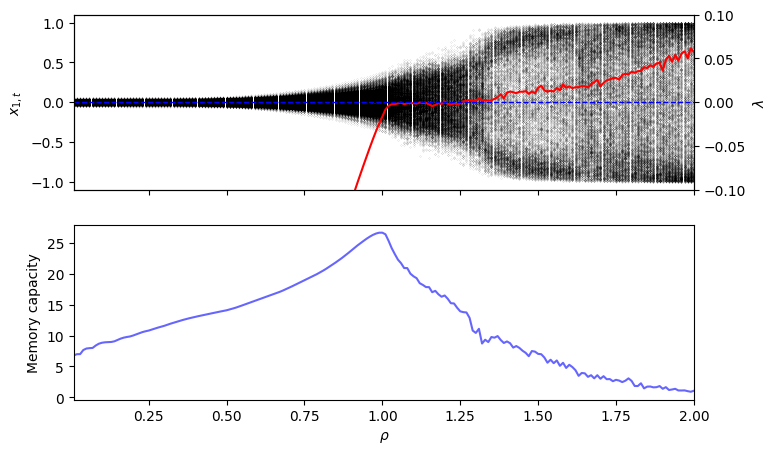